### Test Notebook for Predicting Stroke Risk Based on Lifestyle Habits Project

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, recall_score, precision_score
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

#### Inspect data and calculate statistical variables

In [260]:
stroke_data = pd.read_csv("/content/I05-0006 stroke_risk.csv")
stroke_data.head()

,age,bmi,sleep_hours,smoking_status,exercise_frequency,stroke_risk
0,44,29.4,6.0,Former,High,No
1,76,29.3,10.1,Never,Low,No
2,43,23.6,3.4,Never,Low,Yes
3,59,33.5,5.7,Current,Moderate,No
4,77,26.0,6.1,Never,Low,No


In [261]:
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 500 non-null    int64  
 1   bmi                 500 non-null    float64
 2   sleep_hours         500 non-null    float64
 3   smoking_status      500 non-null    object 
 4   exercise_frequency  500 non-null    object 
 5   stroke_risk         500 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 23.6+ KB


In [262]:
stroke_data.describe()

,age,bmi,sleep_hours
count,500.000000,500.000000,500.000000
mean,55.426000,27.043600,7.039800
std,14.665151,4.918378,1.508797
min,30.000000,12.900000,2.700000
25%,42.000000,23.600000,6.000000
50%,57.000000,26.800000,7.000000
75%,68.000000,30.225000,8.100000
max,79.000000,43.900000,11.900000


In [263]:
stroke_data.isnull().sum()

,0
age,0
bmi,0
sleep_hours,0
smoking_status,0
exercise_frequency,0
stroke_risk,0


### Data Preprocessing

In [264]:
# Function to detect outliers in a numerical column
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"\nOutliers in {column}:")
    print(outliers[[column]])

    return lower_bound, upper_bound

In [265]:
# Checkk for outliers in bmi and sleep_hours (shown originally in EDA)
bmi_lower, bmi_upper = detect_outliers_iqr(stroke_data, "bmi")
sleep_lower, sleep_upper = detect_outliers_iqr(stroke_data, "sleep_hours")


Outliers in bmi:
      bmi
161  43.9
238  40.2
352  12.9

Outliers in sleep_hours:
     sleep_hours
66           2.8
294         11.9
349          2.7
353          2.7


In [266]:
# Function to cap outliers
def cap_outliers(df, column, lower_bound, upper_bound):
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

In [267]:
# cap outliers in bmi and sleep_hours- winsorization
stroke_data = cap_outliers(stroke_data, "bmi", bmi_lower, bmi_upper)
stroke_data = cap_outliers(stroke_data, "sleep_hours", sleep_lower, sleep_upper)

### Feature Engineering

In [268]:
# Add variable to account for age class (below or above 50)
bins = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
labels = ["30–34", "35-39", "40–44", "45-49", "50–54", "55-59", "60–64", "65-69", "70–74", "75-79"]
stroke_data["age_group"] = pd.cut(stroke_data["age"], bins=bins, labels=labels, right=False)
stroke_data.head()

,age,bmi,sleep_hours,smoking_status,exercise_frequency,stroke_risk,age_group
0,44,29.4,6.0,Former,High,No,40–44
1,76,29.3,10.1,Never,Low,No,75-79
2,43,23.6,3.4,Never,Low,Yes,40–44
3,59,33.5,5.7,Current,Moderate,No,55-59
4,77,26.0,6.1,Never,Low,No,75-79


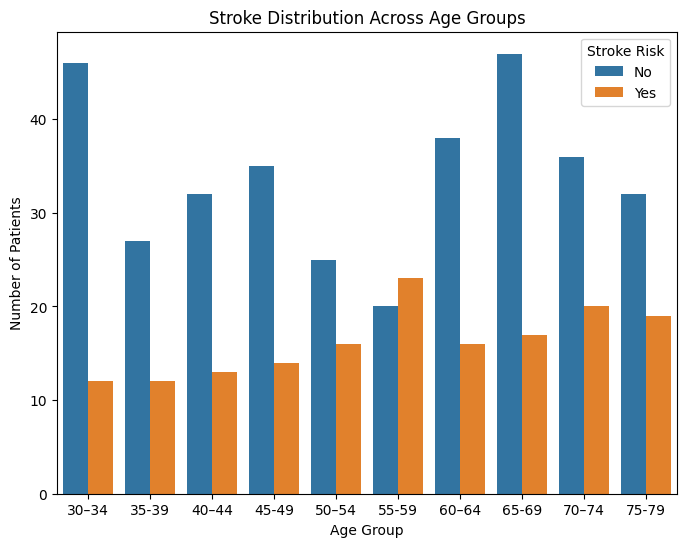

In [269]:
# Plot of stroke risk by age class
age_stroke_counts = stroke_data.groupby(["age_group", "stroke_risk"], observed=True).size().reset_index(name="count")
plt.figure(figsize=(8,6))
sns.barplot(data=age_stroke_counts, x="age_group", y="count", hue="stroke_risk")

plt.title("Stroke Distribution Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Number of Patients")
plt.legend(title="Stroke Risk")
plt.show()

In [270]:
age_stroke_pivot = stroke_data.pivot_table(index="age_group", columns="stroke_risk", values="exercise_frequency",
                                          aggfunc='count',fill_value=0, observed=True)

print(age_stroke_pivot)

stroke_risk  No  Yes
age_group           
30–34        46   12
35-39        27   12
40–44        32   13
45-49        35   14
50–54        25   16
55-59        20   23
60–64        38   16
65-69        47   17
70–74        36   20
75-79        32   19


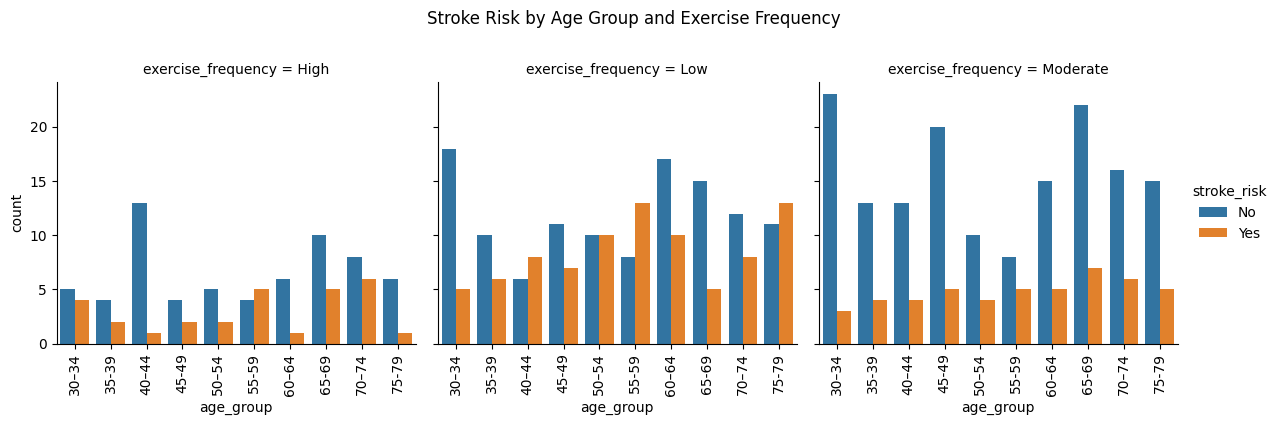

In [271]:
# Plot to understand the trend in exercise level and age by stroke risk class
g = sns.catplot(data=stroke_data, x="age_group", hue="stroke_risk", col="exercise_frequency",
            kind="count", height=4,aspect=1)
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=90)
plt.subplots_adjust(top=0.8)
plt.suptitle("Stroke Risk by Age Group and Exercise Frequency")
plt.show()

In [272]:
# Get unique values from categorical columns
def get_unique_cat(data, col):
  return data[col].unique()

In [273]:
# Get unique values in categorical columns ahead of encoding
categorical_cols = ["smoking_status", "exercise_frequency", "stroke_risk"]
for i in categorical_cols:
  print(f"Unique values in {i}: {get_unique_cat(stroke_data, i)}")

Unique values in smoking_status: ['Former' 'Never' 'Current']
Unique values in exercise_frequency: ['High' 'Low' 'Moderate']
Unique values in stroke_risk: ['No' 'Yes']


In [274]:
# Mapping for encoding categorical columns
cat_cols = ["exercise_frequency", "stroke_risk"]
exercise_frequency_map = {"High":0, "Low":2, "Moderate":1}
stroke_risk_map = {"No":0, "Yes":1}
maps = [exercise_frequency_map, stroke_risk_map]

In [275]:
# Function to perform ordinal encoding on categorical variables
def ordinal_encoding(data, columns, maps):
  data = data.copy()
  for col, mapping in zip(columns, maps):
    data[col] = data[col].map(mapping)
  return data

In [276]:
# Confirm ordinal encoding
stroke_df = ordinal_encoding(stroke_data, cat_cols, maps)
for i in cat_cols:
  print(f"Unique values in {i}: {get_unique_cat(stroke_df, i)}")

Unique values in exercise_frequency: [0 2 1]
Unique values in stroke_risk: [0 1]


In [277]:
# One hot encoding for the smoking status column
stroke_df = pd.get_dummies(stroke_df, columns=["smoking_status"], drop_first=True, dtype=int)

In [278]:
# New variables to account for variable interactions
stroke_df["age_above_50"] = (stroke_df["age"] > 50).astype(int) + 1
stroke_df["exercise_x_age"] = stroke_df["exercise_frequency"] * stroke_df["age"]
stroke_df["exercise_x_bmi"] = stroke_df["exercise_frequency"] * stroke_df["bmi"]
stroke_df["exercise_bmi_50"] = stroke_df["exercise_frequency"] * stroke_df["bmi"] * stroke_df["age_above_50"]
stroke_df["sleep_hours"] = stroke_df["sleep_hours"] * stroke_df["exercise_frequency"]

In [279]:
# Square the age variable to capture non-linearities
stroke_df["age_squared"] = stroke_df["age"] ** 2

In [280]:
# Function to classify bmi
def classify_bmi(bmi):
    if bmi < 18.5:
        return 1
    elif 18.5 <= bmi < 25:
        return 2
    elif 25 <= bmi < 30:
        return 3
    elif 30 <= bmi < 35:
        return 4
    elif 35 <= bmi < 40:
        return 5
    else:
        return 6

stroke_df["bmi_class"] = stroke_df["bmi"].apply(classify_bmi)

In [281]:
stroke_df["bmi_class"].value_counts()

,count
bmi_class,
3,187
2,158
4,111
5,25
1,16
6,3


In [282]:
# Drop rows with stroke class 5
stroke_df = stroke_df[~stroke_df['bmi_class'].isin([5])].reset_index(drop=True)

In [283]:
stroke_df["bmi_class"].value_counts()

,count
bmi_class,
3,187
2,158
4,111
1,16
6,3


In [284]:
# Add weighting to bmi variable
stroke_df["bmi_weighted"] = stroke_df["bmi"] * stroke_df["bmi_class"]

In [285]:
# Round sleep hours to whole number
stroke_df["sleep_rounded"] = stroke_df["sleep_hours"].round()

In [286]:
stroke_df.head()

,age,bmi,sleep_hours,exercise_frequency,stroke_risk,age_group,smoking_status_Former,smoking_status_Never,age_above_50,exercise_x_age,exercise_x_bmi,exercise_bmi_50,age_squared,bmi_class,bmi_weighted,sleep_rounded
0,44,29.4,0.0,0,0,40–44,1,0,1,0,0.0,0.0,1936,3,88.2,0.0
1,76,29.3,20.2,2,0,75-79,0,1,2,152,58.6,117.2,5776,3,87.9,20.0
2,43,23.6,6.8,2,1,40–44,0,1,1,86,47.2,47.2,1849,2,47.2,7.0
3,59,33.5,5.7,1,0,55-59,0,0,2,59,33.5,67.0,3481,4,134.0,6.0
4,77,26.0,12.2,2,0,75-79,0,1,2,154,52.0,104.0,5929,3,78.0,12.0


#### Checking for class imbalance in the target variable

In [287]:
# Value count for target variable to check for class imbalance
class_counts = stroke_df['stroke_risk'].value_counts()
print("Number of samples per class:")
print(class_counts)

Number of samples per class:
stroke_risk
0    324
1    151
Name: count, dtype: int64


In [288]:
plt.rcParams['figure.figsize'] = (8, 6)

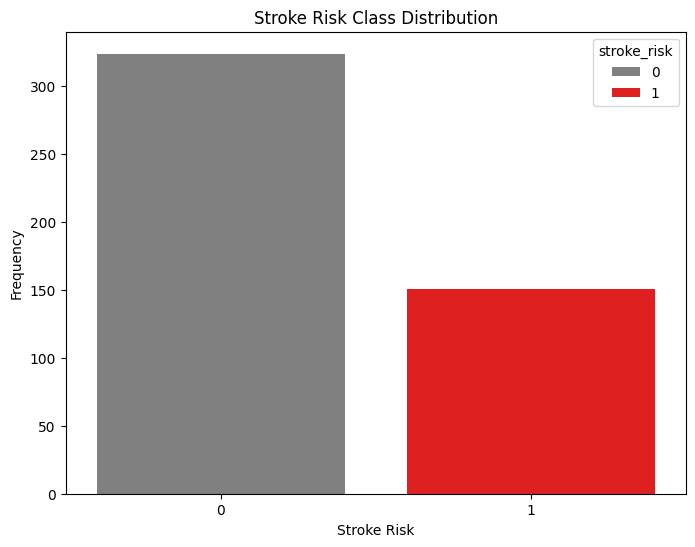

In [289]:
# Visualizing class imbalance
sns.countplot(x='stroke_risk', data=stroke_df, hue="stroke_risk", palette=["gray","red"])
plt.title("Stroke Risk Class Distribution")
plt.xlabel("Stroke Risk")
plt.ylabel("Frequency")
plt.show()

#### Checking for collinearity

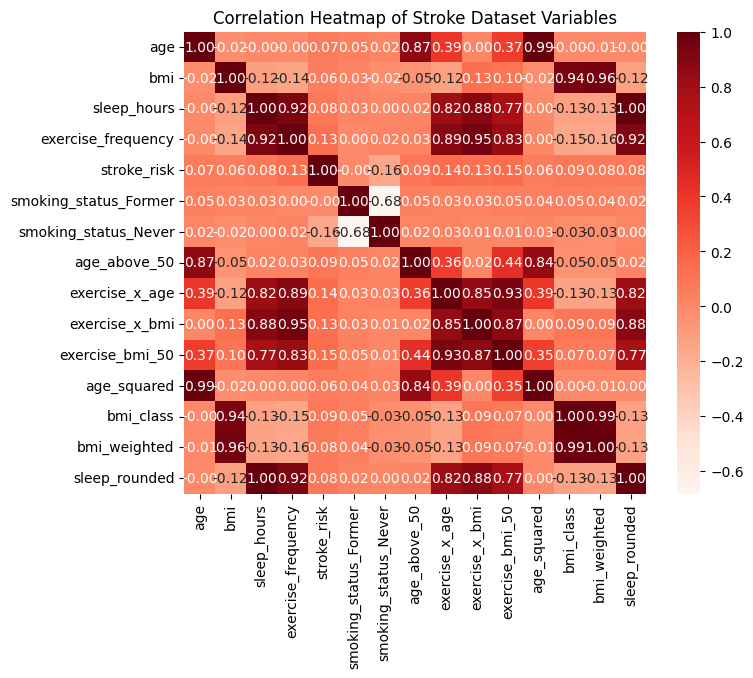

In [290]:
# Confusion matrix to check for collinearity
corr = stroke_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Reds", square=True, cbar=True)
plt.title("Correlation Heatmap of Stroke Dataset Variables")
plt.show()

In [291]:
# Print total columns in dataset
stroke_df.columns

Index(['age', 'bmi', 'sleep_hours', 'exercise_frequency', 'stroke_risk',
       'age_group', 'smoking_status_Former', 'smoking_status_Never',
       'age_above_50', 'exercise_x_age', 'exercise_x_bmi', 'exercise_bmi_50',
       'age_squared', 'bmi_class', 'bmi_weighted', 'sleep_rounded'],
      dtype='object')

In [292]:
# Split features and target variable, drop collinear columns
X = stroke_df.drop(["stroke_risk", "age_group", "age", "age_above_50", "bmi", "sleep_hours"], axis=1)
y = stroke_df["stroke_risk"]

#### Dealing with class imbalance

In [293]:
# Oversampling minority class to 200
smote = SMOTE(sampling_strategy={1: 200}, random_state=42)
X_smote, y_smote = smote.fit_resample(X,y)

In [294]:
# Undersampling majority class to 200
undersample = RandomUnderSampler(random_state=7)
X_under, y_under = undersample.fit_resample(X_smote, y_smote)

In [295]:
# Ensure that target classes are now balanced
class_counts = y_under.value_counts()
print("Number of samples per class:")
print(class_counts)

Number of samples per class:
stroke_risk
0    200
1    200
Name: count, dtype: int64


### Model training and evaluation

In [296]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [297]:
# Grid search parameters
penalty = ['l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
solver = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
max_iter= [100, 1000, 2500, 5000,10000, 20000]

In [298]:
# Create dictionary of parameters for grid search
params = dict(penalty = penalty, C = c_values, solver = solver)
startified_kfold_cv = StratifiedKFold(n_splits=3, shuffle=False)

In [299]:
# Instantiate logistic regressor
lr = LogisticRegression()

In [300]:
# Perform grid search
grid_search = GridSearchCV(estimator = lr, param_grid = params, scoring = 'accuracy', cv = startified_kfold_cv)
grid_search = grid_search.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

In [301]:
# Print best grid search parameters
grid_search.best_params_, grid_search.best_score_

({'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'},
 np.float64(0.5968671016281667))

In [302]:
# Make predictions
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", confusion_mat)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 81.25%
Confusion Matrix:
 [[36  8]
 [ 7 29]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        44
           1       0.78      0.81      0.79        36

    accuracy                           0.81        80
   macro avg       0.81      0.81      0.81        80
weighted avg       0.81      0.81      0.81        80



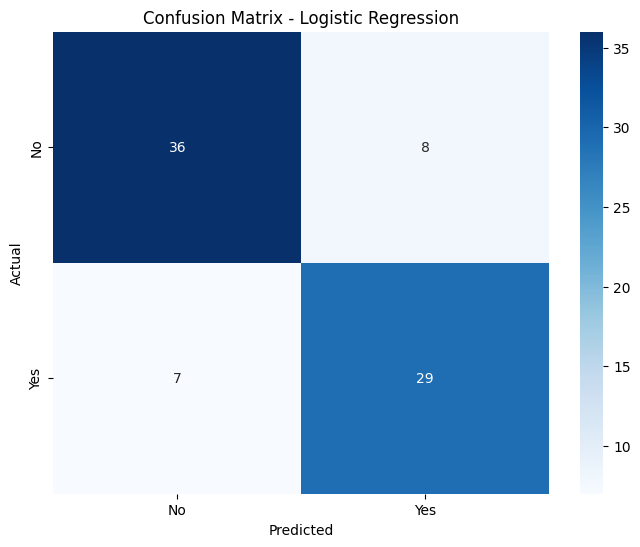

In [303]:
# Plot confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

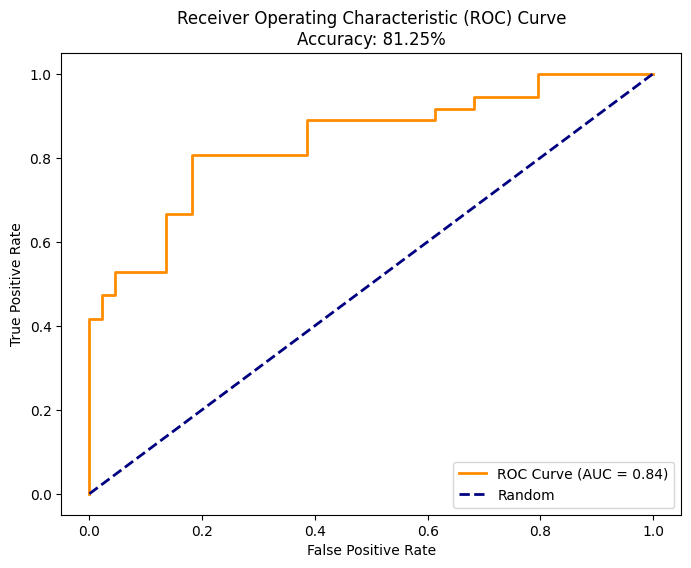

In [304]:
# ROC curve
y_prob = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy * 100))
plt.legend(loc="lower right")
plt.show()

#### Testing different data split ratios

In [305]:
# Test different split ratios
split_ratios = [0.7, 0.75, 0.8, 0.85]
accuracy_list = []
recall_list = []
precision_list = []

In [306]:
# Train model with different split ratios
for test_size in [1 - ratio for ratio in split_ratios]:
    X_trainn, X_testt, y_trainn, y_testt = train_test_split(X_under, y_under, test_size=test_size, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_trainn)
    X_test_scaled = scaler.transform(X_testt)
    model = LogisticRegression(C=1, penalty = "l1", solver = "saga", max_iter=5000)
    model.fit(X_train_scaled, y_trainn)

    y_predd = model.predict(X_test_scaled)

    accuracy_list.append(accuracy_score(y_testt, y_predd))
    recall_list.append(recall_score(y_testt, y_predd))
    precision_list.append(precision_score(y_testt, y_predd))

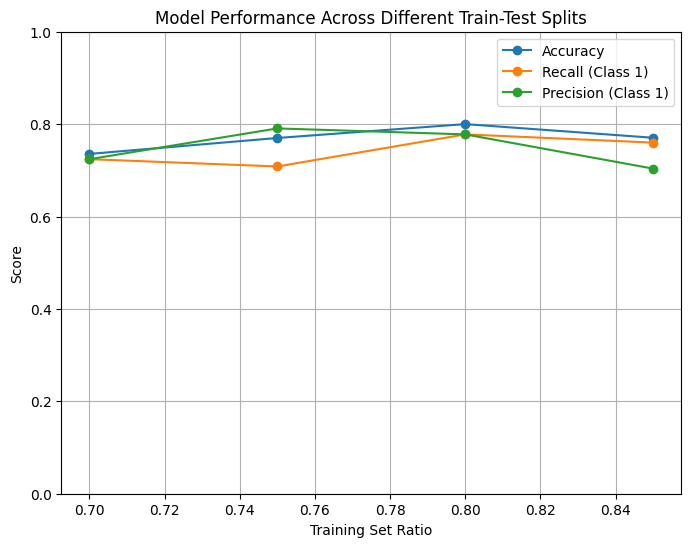

In [307]:
# Plot results
plt.figure(figsize=(8,6))
plt.plot(split_ratios, accuracy_list, marker="o", label="Accuracy")
plt.plot(split_ratios, recall_list, marker="o", label="Recall (Class 1)")
plt.plot(split_ratios, precision_list, marker="o", label="Precision (Class 1)")

plt.title("Model Performance Across Different Train-Test Splits")
plt.xlabel("Training Set Ratio")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [308]:
print("Accuracy:", accuracy_list)
print("Recall:", recall_list)
print("Precision:", precision_list)

Accuracy: [0.7355371900826446, 0.77, 0.8, 0.7704918032786885]
Recall: [0.7241379310344828, 0.7083333333333334, 0.7777777777777778, 0.76]
Precision: [0.7241379310344828, 0.7906976744186046, 0.7777777777777778, 0.7037037037037037]
